In [1]:
from tqdm import tqdm_notebook
from PIL import ImageDraw
import PIL
import os
from shutil import copyfile, rmtree
from IPython.display import Image 

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import random
from shutil import copyfile

import warnings
warnings.simplefilter('ignore')


%matplotlib inline

In [2]:
data_dir = "./locator"

In [3]:
torch.cuda.current_device()

0

# Validation & Training Sets

Move images from the src directories into the train/validation directories

## Setup Terrain Data

In [170]:
src_terrain = "./locator/data/terrain-verified/"
review_terrain = "./locator/data/review/terrain/"
dst_terrain_train = "./locator/data/train/terrain/"
dst_terrain_valid = "./locator/data/valid/terrain/"

for f in os.listdir(dst_terrain_train):
    os.remove(dst_terrain_train+f)
for f in os.listdir(dst_terrain_valid):
    os.remove(dst_terrain_valid+f)
    
for f in os.listdir(src_terrain):
    if random.randint(0,5) >= 1:
        shutil.copy(src_terrain+f, dst_terrain_train+f)
    else:
        shutil.copy(src_terrain+f, dst_terrain_valid+f)

for f in os.listdir(review_terrain):
    if not ".png" in f:
        continue
    if random.randint(0,5) >= 1:
        shutil.copy(review_terrain+f, dst_terrain_train+f)
    else:
        shutil.copy(review_terrain+f, dst_terrain_valid+f)


      
train_num = len(os.listdir(dst_terrain_train))
print("Training terrain: "+str(train_num))
valid_num = len(os.listdir(dst_terrain_valid))
print("Validation terrain: "+str(valid_num))
valid_num = len(os.listdir(dst_terrain_valid))
print("Total terrain: "+str(valid_num+train_num))

Training terrain: 6425
Validation terrain: 1311
Total terrain: 7736


## Setup Player Data

In [171]:
src_player = "./locator/data/player-verified/"
review_player = "./locator/data/review/player/"
dst_player_train = "./locator/data/train/player/"
dst_player_valid = "./locator/data/valid/player/"

for f in os.listdir(dst_player_train):
    os.remove(dst_player_train+f)
for f in os.listdir(dst_player_valid):
    os.remove(dst_player_valid+f)
    
for f in os.listdir(src_player):
    if random.randint(0,5) >= 1:
        shutil.copy(src_player+f, dst_player_train+f)
    else:
        shutil.copy(src_player+f, dst_player_valid+f)
        
for f in os.listdir(review_player):
    if not ".png" in f:
        continue
    if random.randint(0,5) >= 1:
        shutil.copy(review_player+f, dst_player_train+f)
    else:
        shutil.copy(review_player+f, dst_player_valid+f)


train_num = len(os.listdir(dst_player_train))
print("Training player: "+str(train_num))
valid_num = len(os.listdir(dst_player_valid))
print("Validation player: "+str(valid_num))
valid_num = len(os.listdir(dst_player_valid))
print("Total player: "+str(valid_num+train_num))

Training player: 1091
Validation player: 242
Total player: 1333


# Create Data Batch

Collect the 30x30 images which were split from in-game mini-maps. The model predicts if a player is present in the center 10x10 pixels, the extra image around the center 10x10 gives more context for the model's prediction. 

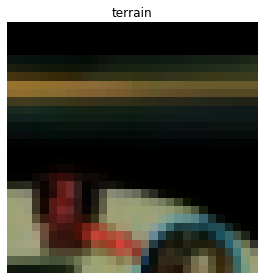

In [172]:
tfms = get_transforms(max_rotate=45, max_zoom=1.1, max_warp=None)
data = ImageDataBunch.from_folder(
    data_dir+"/data", classes=["player", "terrain"], bs=64, ds_tfms=tfms)
data.show_batch(1)

# Train the Model

We train several models, and keep the one with the highest performance. It is still unknown why some models are better, but one explanation from the fastai course may be the initialization of parameters.

## Model Training

In [181]:
lr = 0.02

learn = create_cnn(data, models.resnet101, metrics=[accuracy])
gc.collect()
learn.callbacks = [SaveModelCallback(
    learn, every='improvement', mode='min', name='best')]
learn.fit_one_cycle(1, lr)
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.366137,0.224429,0.922730,00:09


Better model found at epoch 0 with valid_loss value: 0.224429190158844.


epoch,train_loss,valid_loss,accuracy,time
0,0.205065,0.236195,0.920798,00:12
1,0.189074,0.167759,0.932389,00:12
2,0.171693,0.137494,0.943979,00:12
3,0.158085,0.135062,0.949775,00:12
4,0.136695,0.105563,0.959433,00:12
5,0.119758,0.104517,0.964585,00:12
6,0.098913,0.097573,0.964585,00:12
7,0.085329,0.100051,0.961365,00:12


Better model found at epoch 0 with valid_loss value: 0.23619471490383148.
Better model found at epoch 1 with valid_loss value: 0.1677592545747757.
Better model found at epoch 2 with valid_loss value: 0.13749396800994873.
Better model found at epoch 3 with valid_loss value: 0.1350623071193695.
Better model found at epoch 4 with valid_loss value: 0.1055627390742302.
Better model found at epoch 5 with valid_loss value: 0.10451667010784149.
Better model found at epoch 6 with valid_loss value: 0.09757295250892639.


best loss: 9.7

## Full Minimap Test

Display the model's predictions for an entire minimap.

In [182]:
grid_size = 5

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        if l[2] == "terrain":
            continue
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)


def draw_preds(filename, grids):
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(out);
#     imshow(np.asarray(out))


def get_predictions(learner, predictions):
    # Predict the grid image types
    tmp_dir = data_dir + "/tmp"
    test = ImageList.from_folder(tmp_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    for i in range(len(preds[0])):
        max_index = 0
        max_score = 0
        for p in range(len(preds[0][i])):
            if preds[0][i][p] > max_score:
                max_index = p
                max_score = preds[0][i][p]
                
        category = str(learn.data.classes[max_index])
        if category == "terrain":
            continue
        img = test.items[i]
        fname = img.stem
        num = int(fname.split("-")[1])
        name = fname.split("-")[0]
        x = num//1000
        y = num % 1000
        predictions[name].append((x, y, category))

    empty_dir(tmp_dir)
    return predictions


def get_grids(learner, filenames):
    print("locating player positions...")
    padding = 10
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"/tmp"
    empty_dir(tmp_dir)
    z = 0
    numfiles = len(filenames)
    for l in tqdm_notebook(range(numfiles)):
        f = filenames[l]
        if not ".png" in f:
            continue
        im = PIL.Image.open(f)
        imgwidth, imgheight = im.size
        base = os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-padding, i-padding, j + grid_size +
                       padding, i + grid_size + padding)
                a = im.crop(box)
                a.save(data_dir+f"/tmp/{fname}-{j*1000//grid_size+i//grid_size}.png")

        if z % 1000 == 0:
            predictions = get_predictions(learner, predictions)
        z += 1

    if len(os.listdir(tmp_dir)) > 0:
        predictions = get_predictions(learner, predictions)

    return predictions

In [183]:
i = 0

locating player positions...


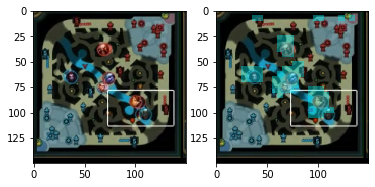

In [184]:
i += 50
s = str(i)
s = "0"*(3-len(s)) + s
filenames = [
    f"games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000{s}.png"]
grids = get_grids(learn, filenames)
base = os.path.basename(filenames[0])
fname = os.path.splitext(base)[0]
draw_preds(filenames[0], grids[fname])

In [185]:
model_path = 'models/'
learn.export(model_path+"locator.pth")

# Collect Games Maps

Gather all the maps from each game into a single "full" folder and "team" folder. These two folders will be the source for training the final map prediction model.

In [737]:
collected_dir = "games_collected/"
games_dir = "games/"
empty_dir(collected_dir + "full")
empty_dir(collected_dir + "team")

games = os.listdir(games_dir)
for g in games:
    if g == ".DS_Store":
        os.remove(games_dir+g)
        continue
    full_dir = games_dir + g + "/full/"
    full_images = os.listdir(full_dir)
    for img in full_images:
        if ".jpg" in img or ".png" in img:
            copyfile(full_dir + img, collected_dir + "full/" + img)

    team_dir = games_dir + g + "/team/"
    team_images = os.listdir(team_dir)
    for img in team_images:
        if ".jpg" in img or ".png" in img:
            copyfile(team_dir + img, collected_dir + "team/" + img)

Full images: 92454
Team images: 92455


In [746]:
print(f"Full images: {len(os.listdir(collected_dir + 'full'))}")
print(f"Team images: {len(os.listdir(collected_dir + 'team'))}")

Full images: 92454
Team images: 92455


In [747]:
full_map = {}
fulls = os.listdir(collected_dir + 'full')
for f in fulls:
    full_map[f] = True

teams = os.listdir(collected_dir + 'team')
for f in teams:
    try:
        full_map[f]
    except:
        print(f)
# shutil.rmtree(collected_dir + 'team/models')

models


## Create Full Map Coordinates

Use the model we trained to predict the coordinates of each player in the maps. This csv will be used as the target in the final map prediction model.

In [5]:
data_dir = "./locator/"
tmp_dir = data_dir + "tmp"
collected_dir = "games_collected/"
empty_dir(tmp_dir)

In [771]:
fnames = []
tags = []
files = os.listdir(collected_dir + "full")

files = [f"{collected_dir}/full/{f}" for f in files]
grids = get_grids(learn, files)

for k, v in grids.items():
    v = [f"{g[0]};{g[1]};{g[2]}" for g in v]
    v.sort()
    v = " ".join(v)
    fnames.append(k)
    tags.append(v)

df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                  columns=['image_name', 'tags'])
convert_dict = {'image_name': str, 'tags': str}
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
df.dropna(subset=['tags'], inplace=True)
df.to_csv(collected_dir+"full_coordinates.csv", index=False)

locating player positions...


## Create Team Map Coordinates

Use the model we trained to predict the coordinates of each player in the team maps. This csv will be used to augment the data in the final prediction model.

In [772]:
fnames = []
tags = []
files = os.listdir(collected_dir + "team")

files = [f"{collected_dir}/team/{f}" for f in files]
grids = get_grids(best_learn, files)

for k, v in grids.items():
    v = [f"{g[0]};{g[1]};{g[2]}" for g in v]
    v.sort()
    v = " ".join(v)
    fnames.append(k)
    tags.append(v)

df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                  columns=['image_name', 'tags'])
convert_dict = {'image_name': str, 'tags': str}
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
df.dropna(subset=['tags'], inplace=True)
df.to_csv(collected_dir+"team_coordinates.csv", index=False)

locating player positions...


# Create Composite Maps

Merge a sequence of maps together to give the model an idea of where players are moving. We only need to merge the team mini-maps, the full mini-maps are only used to extract the coordinates of all player positions. The predictions are made on the player's maps.

## Composite Function

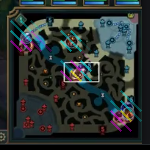

In [6]:
def create_composite(previous_positions, img):
    grid_size = 10
    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = PIL.ImageDraw.Draw(overlay)

    num_positions = len(previous_positions)
    for i in range(num_positions):
        grid = previous_positions[i]
        grid = grid.split(" ")
        grid = [g.split(";") for g in grid]
        grid = [(int(g[0]), int(g[1]), g[2]) for g in grid]

        alpha = int(128 * i/num_positions)
        for l in grid:
            fill = (255, 0, 255, alpha)
            if l[2] == "blue":
                fill = (0, 255, 255, alpha)
            if l[2] == "blue-red":
                fill = (255, 255, 0, alpha)

            x1 = l[0] * grid_size
            x2 = x1 + grid_size
            y1 = l[1] * grid_size
            y2 = y1 + grid_size

            p1 = (x1, y1)
            p2 = (x2, y2)

            draw.line([p1, p2], fill=fill, width=2)

    out = PIL.Image.alpha_composite(img, overlay)
    return out

# Test create_composite
names = ['hka_isg_4_2019_0000000000', 'hka_isg_4_2019_0000000001', 'hka_isg_4_2019_0000000002', 'hka_isg_4_2019_0000000003', 'hka_isg_4_2019_0000000004', 'hka_isg_4_2019_0000000005', 'hka_isg_4_2019_0000000006', 'hka_isg_4_2019_0000000007',
         'hka_isg_4_2019_0000000008', 'hka_isg_4_2019_0000000009', 'hka_isg_4_2019_0000000010', 'hka_isg_4_2019_0000000011', 'hka_isg_4_2019_0000000012', 'hka_isg_4_2019_0000000013', 'hka_isg_4_2019_0000000014', 'hka_isg_4_2019_0000000015']


image_tags = {}
with open(collected_dir+"team_coordinates.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader)  # Skip the first line
    for row in reader:
        image_tags[row[0]] = row[1]

previous_positions = []
for n in names:
    previous_positions.append(image_tags[n])
img = PIL.Image.open(collected_dir+"team/hka_isg_4_2019_0000000015.png")
res = create_composite(previous_positions, img)
display(res)

In [830]:
games_dir = "games/"
game_names = os.listdir(games_dir)
for game in tqdm_notebook(game_names):
    game_dir = f"{games_dir}{game}/team"    
    images = os.listdir(game_dir)
    images.sort()
    for i in range(20, len(images)): 
        image_names = [images[i]]*15
        if i >= 15:
            image_names = images[i-15:i]
        try:
            image_names = [im.replace(".png", "") for im in image_names]
            previous_positions = [image_tags[im] for im in image_names]
            img = PIL.Image.open(f"{collected_dir}/team/{image_names[-1]}.png").convert("RGBA")
            res = create_composite(previous_positions, img)
            res.save(f"{collected_dir}/composite/{image_names[-1]}.png")
        except:
            print(image_names[-1])

ig_tl_1_worlds_oct_12_2019_0000000019
ig_tl_1_worlds_oct_12_2019_0000000020
ig_tl_1_worlds_oct_12_2019_0000000021
ig_tl_1_worlds_oct_12_2019_0000000022
ig_tl_1_worlds_oct_12_2019_0000000023
ig_tl_1_worlds_oct_12_2019_0000000024
ig_tl_1_worlds_oct_12_2019_0000000025
ig_tl_1_worlds_oct_12_2019_0000000026
ig_tl_1_worlds_oct_12_2019_0000000027
ig_tl_1_worlds_oct_12_2019_0000000028
ig_tl_1_worlds_oct_12_2019_0000000029
ig_tl_1_worlds_oct_12_2019_0000000030
ig_tl_1_worlds_oct_12_2019_0000000031
ig_tl_1_worlds_oct_12_2019_0000000032
ig_tl_1_worlds_oct_12_2019_0000000033
ig_tl_1_worlds_oct_12_2019_0000000034
ig_tl_1_worlds_oct_12_2019_0000000035
ig_tl_1_worlds_oct_12_2019_0000000036
ig_tl_1_worlds_oct_12_2019_0000000037
dfm_spy_worlds_2019_0000000706
dfm_spy_worlds_2019_0000000707
dfm_spy_worlds_2019_0000000708
dfm_spy_worlds_2019_0000000709
dfm_spy_worlds_2019_0000000710
dfm_spy_worlds_2019_0000000711
dfm_spy_worlds_2019_0000000712
dfm_spy_worlds_2019_0000000713
dfm_spy_worlds_2019_0000000714

fpx_gam_1_worlds_oct_17_2019_0000001394
fpx_gam_1_worlds_oct_17_2019_0000001395
fpx_gam_1_worlds_oct_17_2019_0000001396
fpx_gam_1_worlds_oct_17_2019_0000001397
fpx_gam_1_worlds_oct_17_2019_0000001398
fnc_skt_1_worlds_oct_12_2019_0000000096
fnc_skt_1_worlds_oct_12_2019_0000000097
fnc_skt_1_worlds_oct_12_2019_0000000098
fnc_skt_1_worlds_oct_12_2019_0000000099
fnc_skt_1_worlds_oct_12_2019_0000000100
fnc_skt_1_worlds_oct_12_2019_0000000101
fnc_skt_1_worlds_oct_12_2019_0000000102
fnc_skt_1_worlds_oct_12_2019_0000000103
fnc_skt_1_worlds_oct_12_2019_0000000104
fnc_skt_1_worlds_oct_12_2019_0000000105
fnc_skt_1_worlds_oct_12_2019_0000000106
fnc_skt_1_worlds_oct_12_2019_0000000107
fnc_skt_1_worlds_oct_12_2019_0000000108
fnc_skt_1_worlds_oct_12_2019_0000000109
fnc_skt_1_worlds_oct_12_2019_0000000110
fnc_skt_1_worlds_oct_12_2019_0000000111
fnc_skt_1_worlds_oct_12_2019_0000000112
fnc_skt_1_worlds_oct_12_2019_0000000113
dwg_lk_3_worlds_2019_0000001188
dwg_lk_3_worlds_2019_0000001189
dwg_lk_3_worlds_